In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


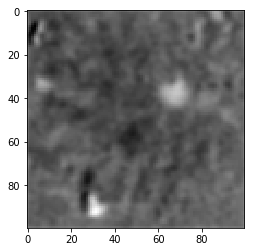

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'lisa_07' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 2000
l1_coeff = 0.1
thr = 0.4 #threshold for one hot pixel* sim score
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


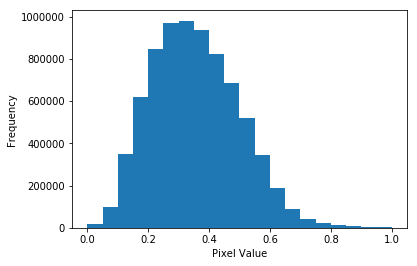

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


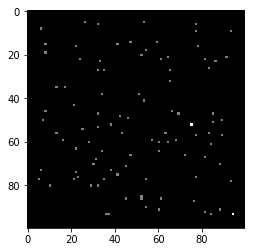

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size):
    
    #activity_regularizer=l1(0.1)
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord=tf.pad(inps, paddings, "REFLECT")
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    act1=tf.keras.layers.ReLU()(coord1)
    
    #paddings1 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    #coord2=tf.pad(act1, paddings1, "REFLECT")
    pool1=MaxPooling2D((2, 2), padding='same')(act1)
    #obj=MaxBlurPool()
    #pool1=obj(act1)
    
    #conv block2
    
    #act1=tf.keras.layers.ReLU()(coord1)
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord3=tf.pad(pool1, paddings2, "REFLECT")

    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu')(coord3)
    
    #paddings3 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    #coord4=tf.pad(conv1, paddings3, "REFLECT")
    pool2=MaxPooling2D((2, 2),padding='same')(conv1)
    
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord5=tf.pad(pool2, paddings4, "REFLECT")
    #x = Conv2D(128, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(0.1))(pool2)
    x = Conv2D(128, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x) 
    
    paddings5 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings5, "REFLECT")
    x = Conv2D(64, 3, padding = 'valid', activation = 'relu')(x)
    # x = Conv2D(64, 3, padding = 'same', activation = 'relu',activity_regularizer=l1(0.1))(x)
    x = UpSampling2D(size=(2,2),interpolation='bilinear')(x)
    paddings6 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings6, "REFLECT")
    x = Conv2D(16, 3, padding = 'valid', activation = 'relu')(x)
    paddings7 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings7, "REFLECT")
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid', activity_regularizer=l1(0.1))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = bxent(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = bxent(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = bxent(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = bxent(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

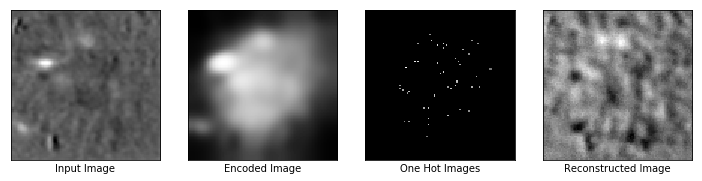

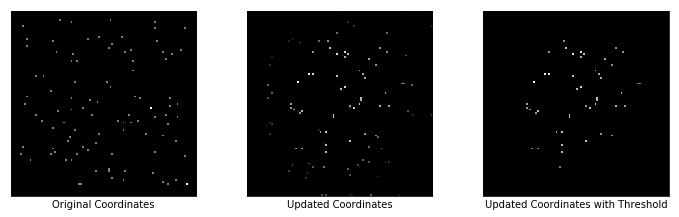

Epochs: 100, Reconstruction Loss: 0.0025413441471755505
Regularizer Loss: 1677.671142578125, Total Loss: 1677.6737060546875
Encoder Loss: 6.3135223388671875
Max Similarity scores: 0.8885444402694702
Updated Coordinates: [[[0.7548597  0.21968941]]]
Gradient global min:-0.00023260508896782994, max:0.0001589620515005663
Gradient encoder min:-1.524864673614502, max:2.628540515899658
Gradient learnable coords min:-5.950936156295938e-06, max:5.975268777547171e-06



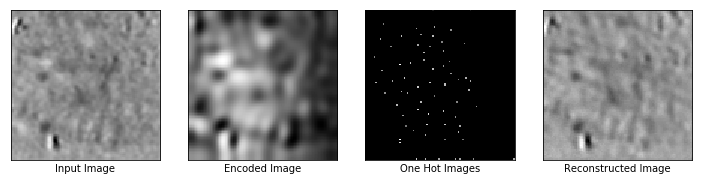

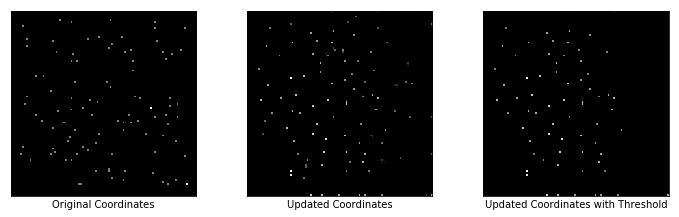

Epochs: 200, Reconstruction Loss: 0.0016407094663009048
Regularizer Loss: 1848.97119140625, Total Loss: 1848.9727783203125
Encoder Loss: 4.624204635620117
Max Similarity scores: 0.883350133895874
Updated Coordinates: [[[0.7552371  0.17461617]]]
Gradient global min:-0.0007058313931338489, max:0.0007331405649892986
Gradient encoder min:-1.3348742723464966, max:2.3187804222106934
Gradient learnable coords min:-2.3964654246810824e-05, max:1.4811981600360014e-05



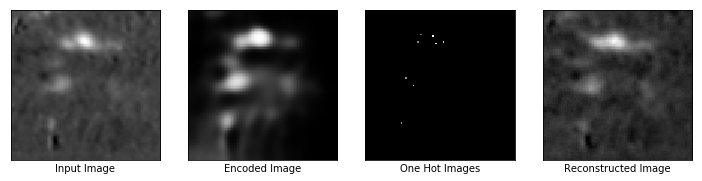

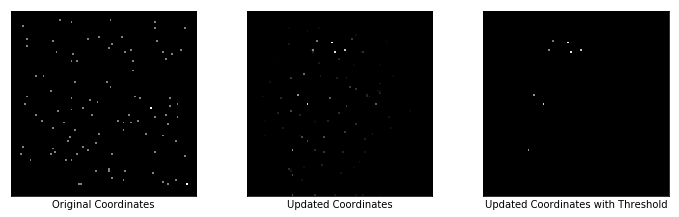

Epochs: 300, Reconstruction Loss: 0.001479674014262855
Regularizer Loss: 1534.5458984375, Total Loss: 1534.54736328125
Encoder Loss: 3.2706804275512695
Max Similarity scores: 0.9244234561920166
Updated Coordinates: [[[0.7548489  0.16612521]]]
Gradient global min:-0.005623712204396725, max:0.005586531944572926
Gradient encoder min:-1.5845599174499512, max:1.4802767038345337
Gradient learnable coords min:-3.5198456316720694e-05, max:1.6344976756954566e-05



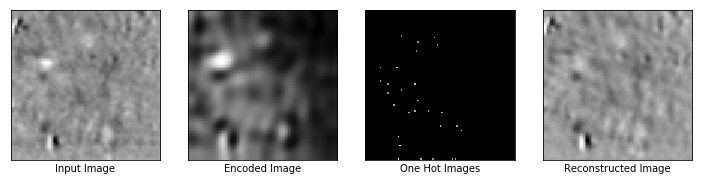

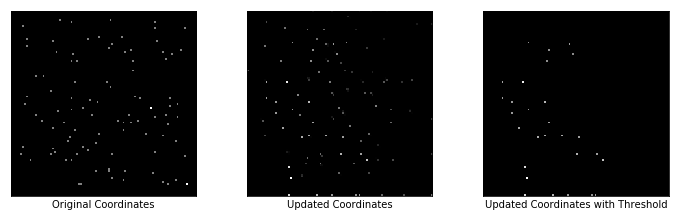

Epochs: 400, Reconstruction Loss: 0.0012641290668398142
Regularizer Loss: 1339.352783203125, Total Loss: 1339.35400390625
Encoder Loss: 2.5999436378479004
Max Similarity scores: 0.7572562098503113
Updated Coordinates: [[[0.73441625 0.1465203 ]]]
Gradient global min:-0.0022776892874389887, max:0.001954567851498723
Gradient encoder min:-1.53303861618042, max:1.279010534286499
Gradient learnable coords min:-2.593394492578227e-05, max:7.573562470497563e-05



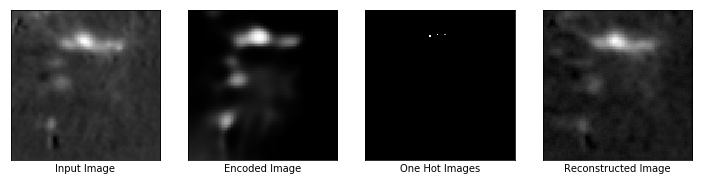

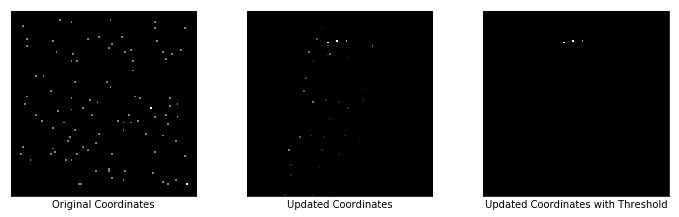

Epochs: 500, Reconstruction Loss: 0.001212068716995418
Regularizer Loss: 1168.060546875, Total Loss: 1168.061767578125
Encoder Loss: 2.295982837677002
Max Similarity scores: 0.8160015940666199
Updated Coordinates: [[[0.7560698  0.10797628]]]
Gradient global min:-0.006064151413738728, max:0.004562932997941971
Gradient encoder min:-1.535864233970642, max:1.395364761352539
Gradient learnable coords min:-2.1407147869467735e-05, max:1.272994813916739e-05



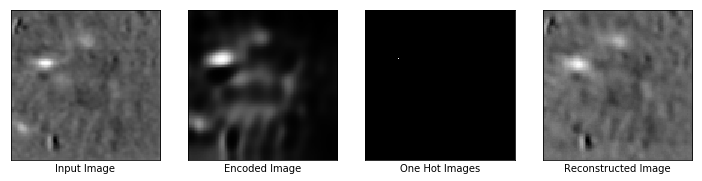

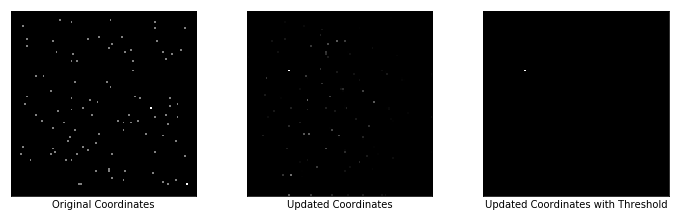

Epochs: 600, Reconstruction Loss: 0.0018476106924936175
Regularizer Loss: 1039.740478515625, Total Loss: 1039.7423095703125
Encoder Loss: 1.7723361253738403
Max Similarity scores: 0.8320176005363464
Updated Coordinates: [[[0.77761346 0.03997404]]]
Gradient global min:-0.005348258186131716, max:0.007931125350296497
Gradient encoder min:-1.5071196556091309, max:1.481113314628601
Gradient learnable coords min:-5.3022180509287864e-05, max:2.7568739824346267e-05



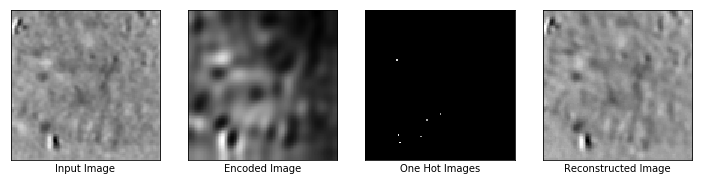

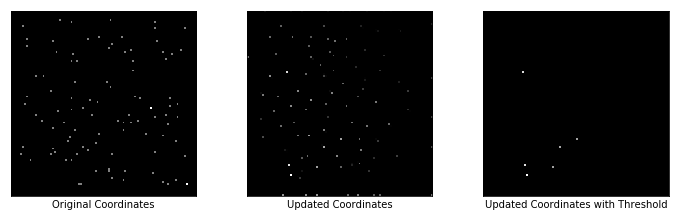

Epochs: 700, Reconstruction Loss: 0.0008394269971176982
Regularizer Loss: 1056.6484375, Total Loss: 1056.6492919921875
Encoder Loss: 1.9038928747177124
Max Similarity scores: 0.630125105381012
Updated Coordinates: [[[0.70277107 0.11059836]]]
Gradient global min:-0.0034911702387034893, max:0.003887998405843973
Gradient encoder min:-1.5756399631500244, max:1.5893865823745728
Gradient learnable coords min:-1.3391148968366906e-05, max:1.194530341308564e-05



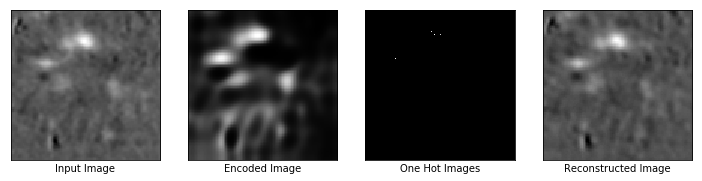

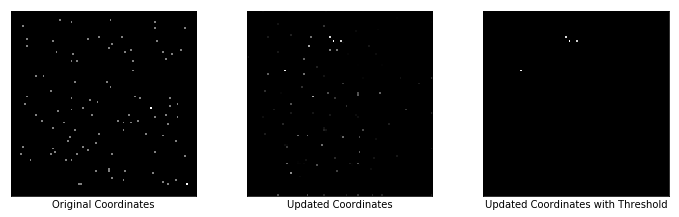

Epochs: 800, Reconstruction Loss: 0.0006491959793493152
Regularizer Loss: 1102.506591796875, Total Loss: 1102.5072021484375
Encoder Loss: 1.6843589544296265
Max Similarity scores: 0.5385836958885193
Updated Coordinates: [[[0.70666236 0.09995361]]]
Gradient global min:-0.00013585519627667964, max:0.00016913255967665464
Gradient encoder min:-1.5546046495437622, max:1.448822259902954
Gradient learnable coords min:-1.1287934285064694e-05, max:1.2365700058580842e-05



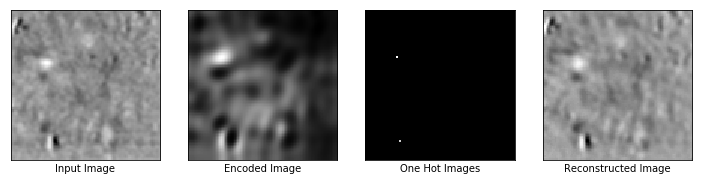

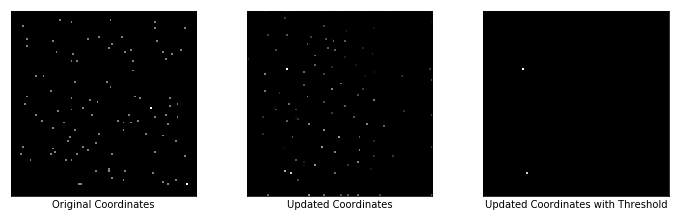

Epochs: 900, Reconstruction Loss: 0.0006450368673540652
Regularizer Loss: 1065.8487548828125, Total Loss: 1065.849365234375
Encoder Loss: 1.3634909391403198
Max Similarity scores: 0.5831457376480103
Updated Coordinates: [[[0.6857944  0.08911259]]]
Gradient global min:-0.00021761706739198416, max:7.01439639669843e-05
Gradient encoder min:-1.6053717136383057, max:1.2407867908477783
Gradient learnable coords min:-3.0414901175390696e-06, max:7.6158262345416006e-06



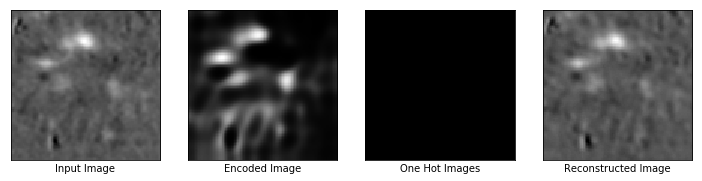

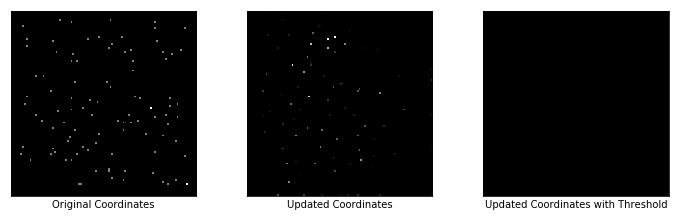

Epochs: 1000, Reconstruction Loss: 0.0006196932517923415
Regularizer Loss: 1115.629638671875, Total Loss: 1115.6302490234375
Encoder Loss: 1.328576683998108
Max Similarity scores: 0.37963518500328064
Updated Coordinates: [[[0.71851325 0.10204208]]]
Gradient global min:-0.0003691960882861167, max:0.0004438451142050326
Gradient encoder min:-1.487227201461792, max:1.0532124042510986
Gradient learnable coords min:-8.715211151866242e-06, max:3.1768154258315917e-06



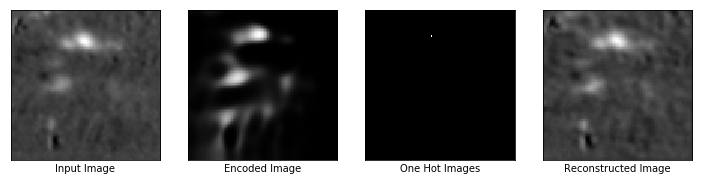

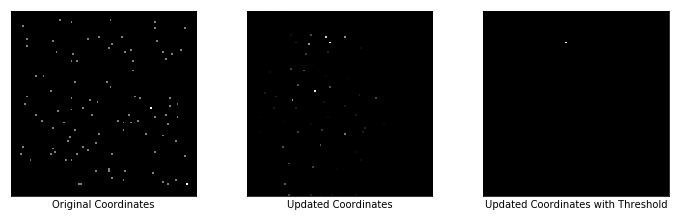

Epochs: 1100, Reconstruction Loss: 0.0012448022607713938
Regularizer Loss: 1105.473876953125, Total Loss: 1105.47509765625
Encoder Loss: 1.2976548671722412
Max Similarity scores: 0.45630937814712524
Updated Coordinates: [[[0.75856566 0.08190615]]]
Gradient global min:-0.022986236959695816, max:0.0071748304180800915
Gradient encoder min:-1.6997640132904053, max:1.150170922279358
Gradient learnable coords min:-6.042838322173338e-06, max:1.2385498848743737e-05



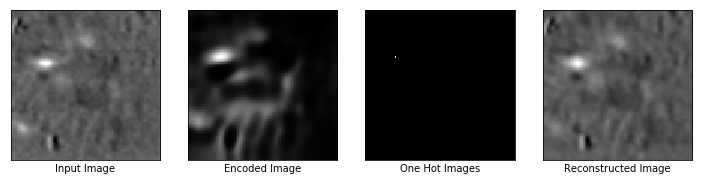

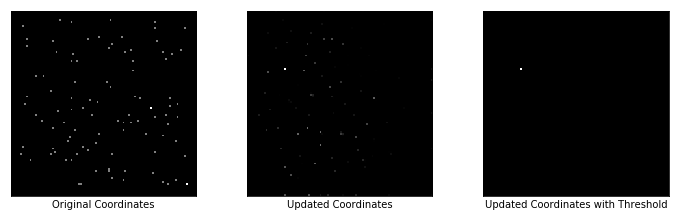

Epochs: 1200, Reconstruction Loss: 0.0006803202559240162
Regularizer Loss: 1157.455810546875, Total Loss: 1157.45654296875
Encoder Loss: 1.1942815780639648
Max Similarity scores: 0.5475406050682068
Updated Coordinates: [[[0.73936534 0.0711131 ]]]
Gradient global min:-0.0013081739889457822, max:0.00212179240770638
Gradient encoder min:-1.4761085510253906, max:0.9638288021087646
Gradient learnable coords min:-3.722934025063296e-06, max:1.500385315011954e-05



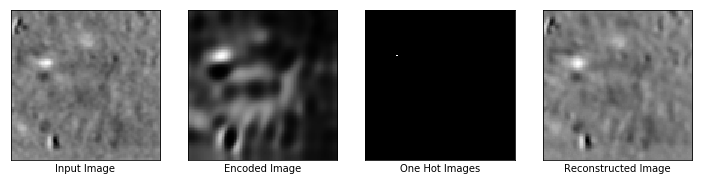

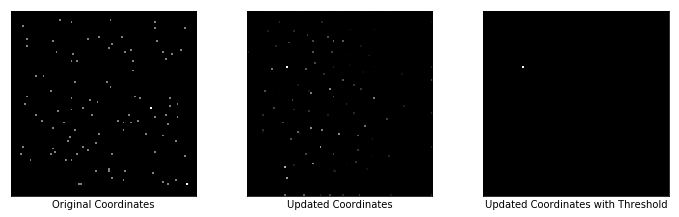

Epochs: 1300, Reconstruction Loss: 0.0006599657936021686
Regularizer Loss: 1195.9122314453125, Total Loss: 1195.912841796875
Encoder Loss: 1.136539340019226
Max Similarity scores: 0.48628485202789307
Updated Coordinates: [[[0.68639076 0.09957212]]]
Gradient global min:-0.0016646534204483032, max:0.0009952420368790627
Gradient encoder min:-1.2546555995941162, max:0.7611995339393616
Gradient learnable coords min:-4.565994004224194e-06, max:9.574850082572084e-06



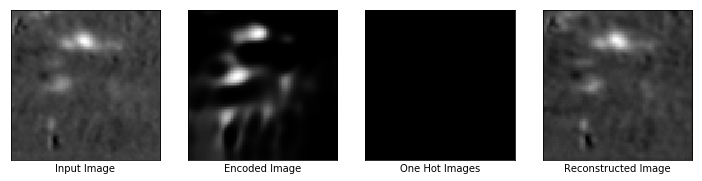

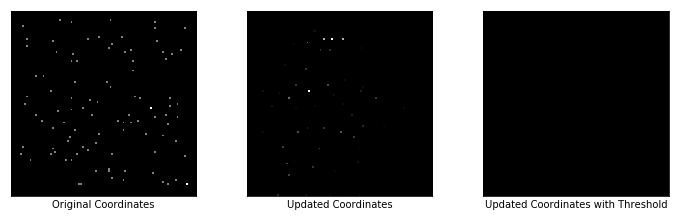

Epochs: 1400, Reconstruction Loss: 0.0006336495280265808
Regularizer Loss: 1213.026123046875, Total Loss: 1213.0267333984375
Encoder Loss: 1.0411514043807983
Max Similarity scores: 0.40238824486732483
Updated Coordinates: [[[0.7151221  0.07707685]]]
Gradient global min:-0.00043544088839553297, max:0.0009563002968207002
Gradient encoder min:-1.2754021883010864, max:0.8605449199676514
Gradient learnable coords min:-2.5453464331803843e-05, max:2.0914549168082885e-05



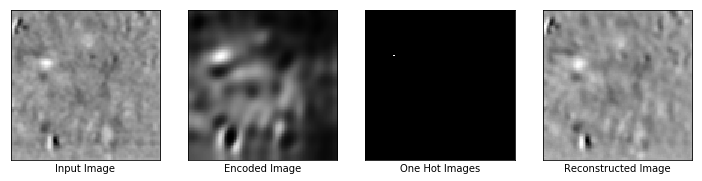

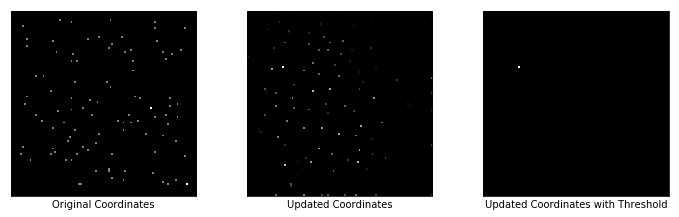

Epochs: 1500, Reconstruction Loss: 0.0006392151699401438
Regularizer Loss: 1220.17431640625, Total Loss: 1220.1749267578125
Encoder Loss: 1.056541085243225
Max Similarity scores: 0.43507689237594604
Updated Coordinates: [[[0.67330563 0.0550015 ]]]
Gradient global min:-0.00028653707704506814, max:0.0005373528110794723
Gradient encoder min:-1.285393476486206, max:0.7916386723518372
Gradient learnable coords min:-6.190800377225969e-06, max:4.164467827649787e-05



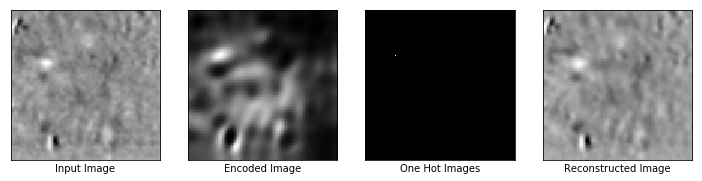

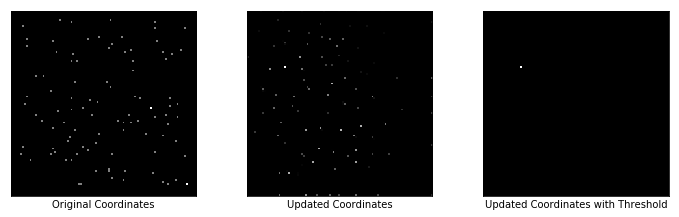

Epochs: 1600, Reconstruction Loss: 0.0008578974520787597
Regularizer Loss: 1236.260986328125, Total Loss: 1236.2618408203125
Encoder Loss: 0.9326657056808472
Max Similarity scores: 0.4180806577205658
Updated Coordinates: [[[0.64628214 0.07940587]]]
Gradient global min:-0.004362985957413912, max:0.006328320596367121
Gradient encoder min:-1.3477206230163574, max:0.7507523894309998
Gradient learnable coords min:-0.0001996116479858756, max:4.7350193199235946e-05



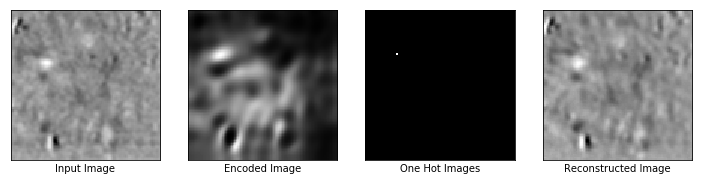

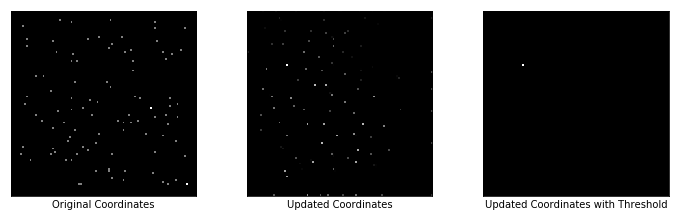

Epochs: 1700, Reconstruction Loss: 0.0006502247415482998
Regularizer Loss: 1303.7349853515625, Total Loss: 1303.735595703125
Encoder Loss: 0.9756253957748413
Max Similarity scores: 0.41777005791664124
Updated Coordinates: [[[0.6354881  0.03867629]]]
Gradient global min:-0.0016330389771610498, max:0.0026056324131786823
Gradient encoder min:-1.3348784446716309, max:0.7256669402122498
Gradient learnable coords min:-1.1055143659177702e-05, max:6.3578481785953045e-06



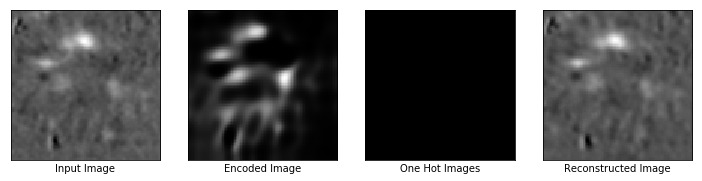

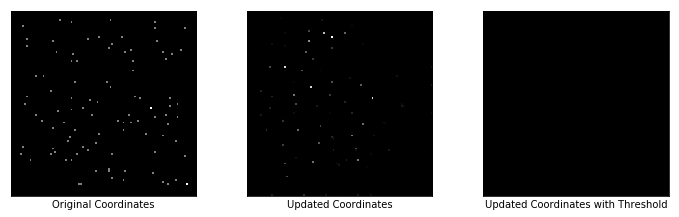

Epochs: 1800, Reconstruction Loss: 0.0006293841288425028
Regularizer Loss: 1444.74951171875, Total Loss: 1444.7501220703125
Encoder Loss: 1.0082342624664307
Max Similarity scores: 0.3525077700614929
Updated Coordinates: [[[0.6566847  0.07086688]]]
Gradient global min:-0.0022473118733614683, max:0.001805826905183494
Gradient encoder min:-1.3250751495361328, max:0.680988609790802
Gradient learnable coords min:-1.7773119907360524e-05, max:1.2740842976199929e-05



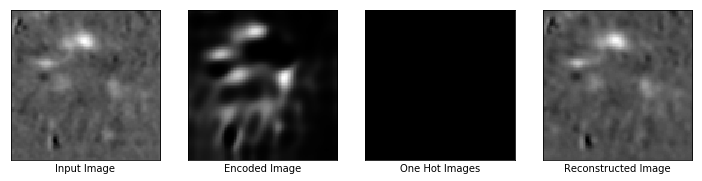

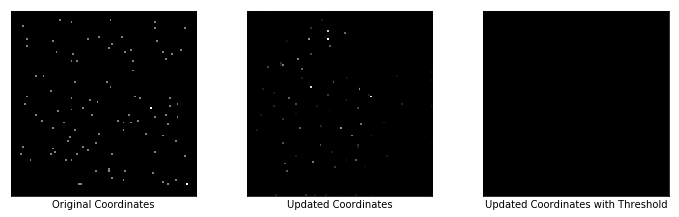

Epochs: 1900, Reconstruction Loss: 0.000573021243326366
Regularizer Loss: 1682.78515625, Total Loss: 1682.7857666015625
Encoder Loss: 0.9513494968414307
Max Similarity scores: 0.33801451325416565
Updated Coordinates: [[[0.676364   0.05916525]]]
Gradient global min:-0.0013482639333233237, max:0.0010812386171892285
Gradient encoder min:-1.0675421953201294, max:0.601241409778595
Gradient learnable coords min:-2.397041316726245e-05, max:1.9219127352698706e-05



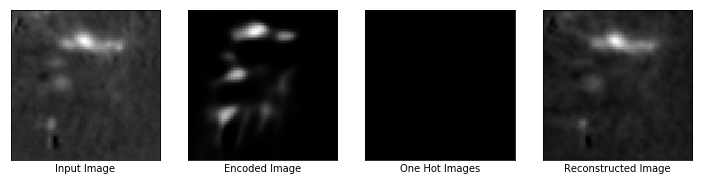

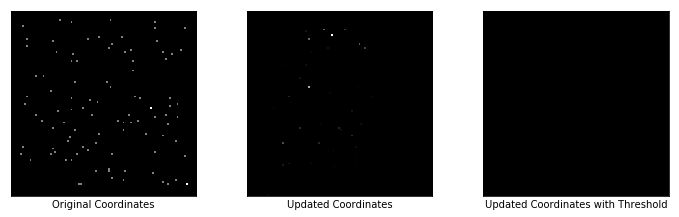

Epochs: 2000, Reconstruction Loss: 0.0005300813936628401
Regularizer Loss: 1958.57080078125, Total Loss: 1958.5712890625
Encoder Loss: 0.949977695941925
Max Similarity scores: 0.34561988711357117
Updated Coordinates: [[[0.64409894 0.06825456]]]
Gradient global min:-0.0004367571964394301, max:0.0007319216383621097
Gradient encoder min:-1.026664137840271, max:0.642565906047821
Gradient learnable coords min:-1.1784673915826716e-05, max:6.633869361394318e-06


In [12]:
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                              IMG_SIZE, BATCH_SIZE,
                                                                                                              neuron_multi = True,
                                                                                                             one_hot_thr = True)
                                                                                                             
                                                                                                        
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list_global.append(loss[0])
    loss_list_encoded_one_hot.append(loss[1])
    regulariser_loss_list.append(loss[-1])
    
    #note for loss indices
    #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
        print("Epochs: {}, Reconstruction Loss: {}".format(epochs, loss[0].numpy()))
        print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
        print("Encoder Loss: {}".format(loss[1].numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
        print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
        print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
        #append to list 
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [15]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [16]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [18]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [19]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

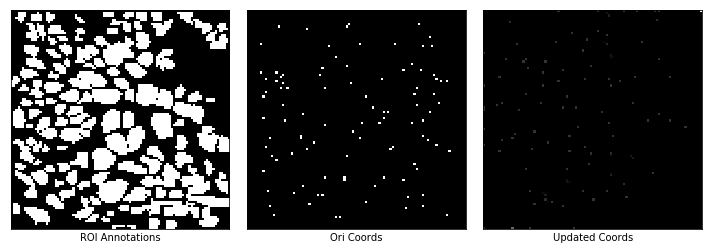

In [20]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.020000001
Counts:  196


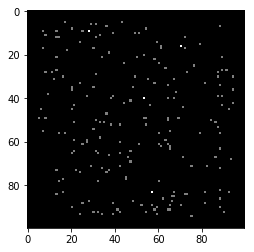

In [21]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

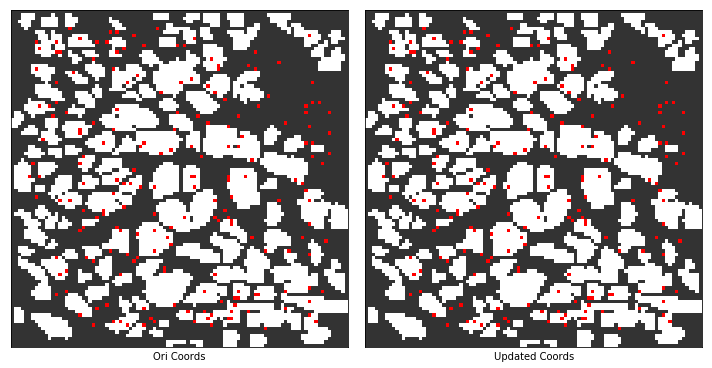

In [22]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [23]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0102
True Negatives:  0.0094
False Positive Ratio:  0.4084
False Negatives Ratio:  0.5720000000000001
F1 score:  0.04655408489274305


---

# Similarity Scores with Threshold

In [26]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

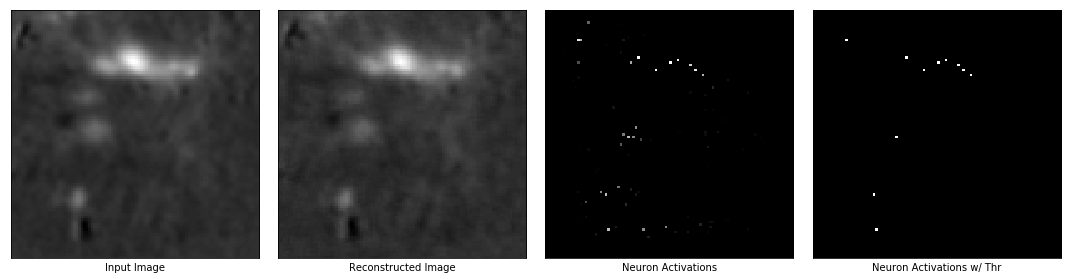

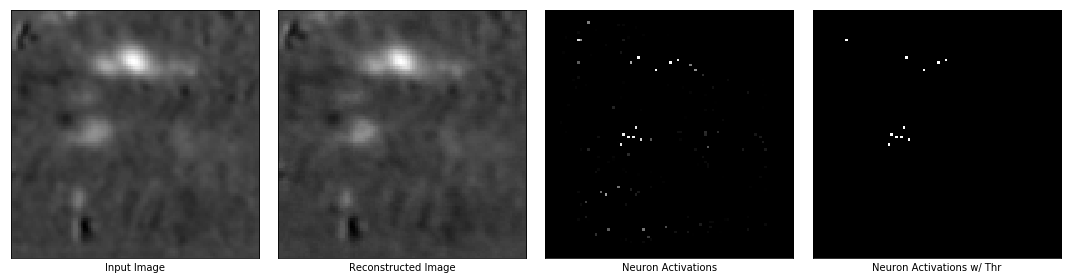

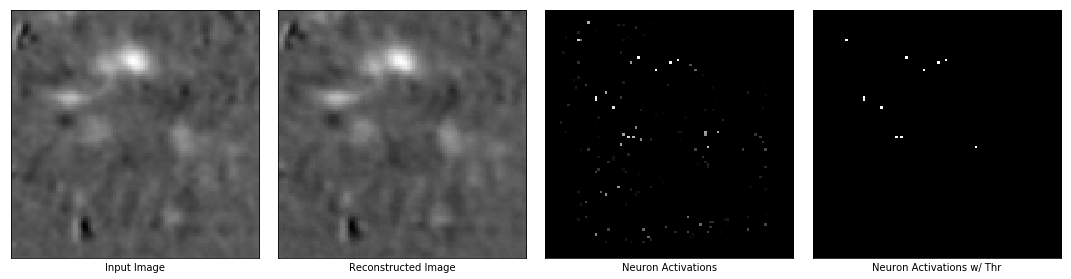

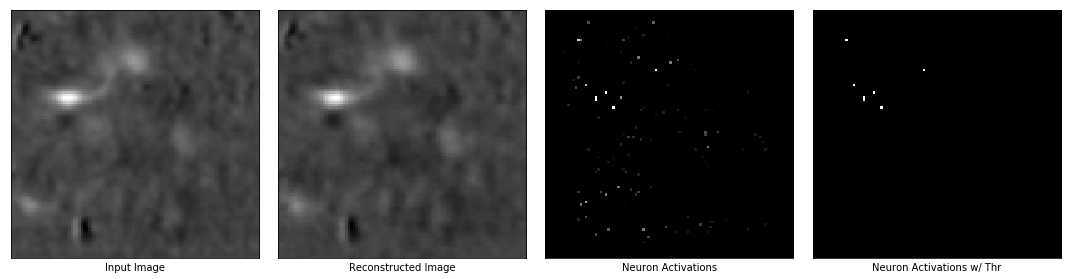

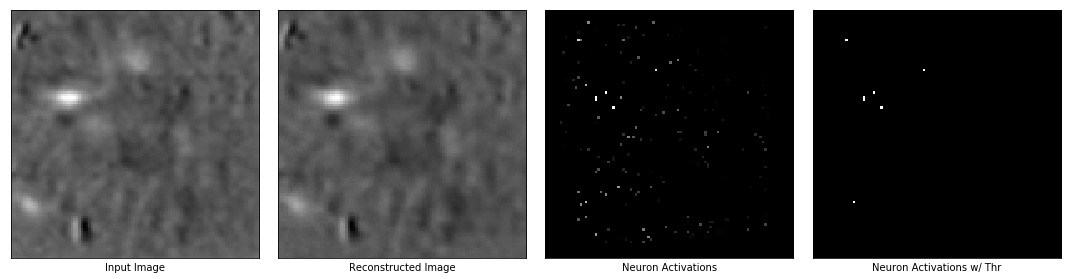

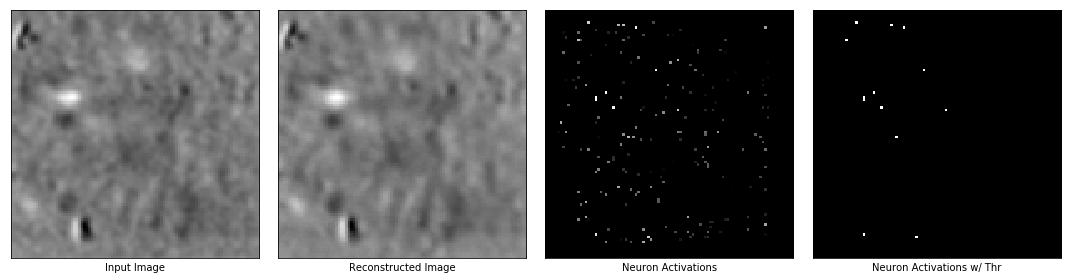

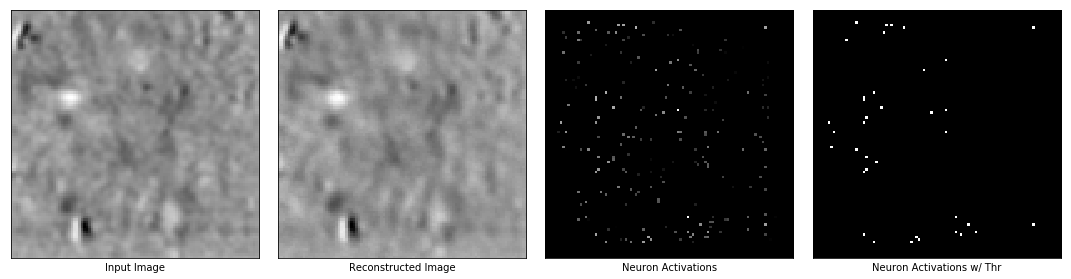

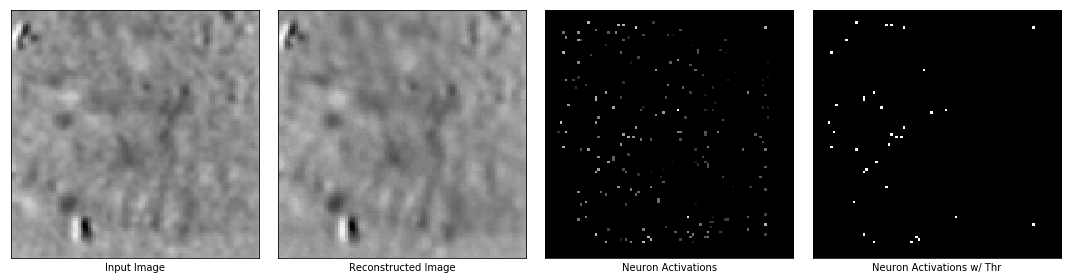

In [27]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

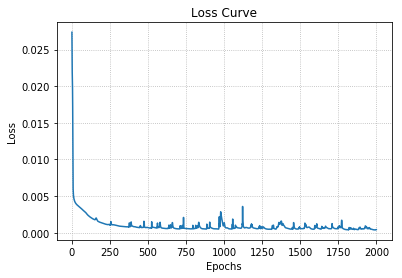

In [28]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [29]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [30]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_8
coord_conv_9
activation_2
up_sampling2d_9
conv2d_36
activation_3
conv2d_37


In [31]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


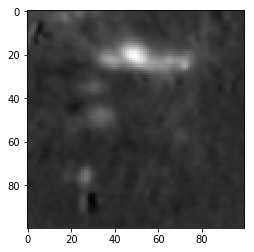

In [32]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


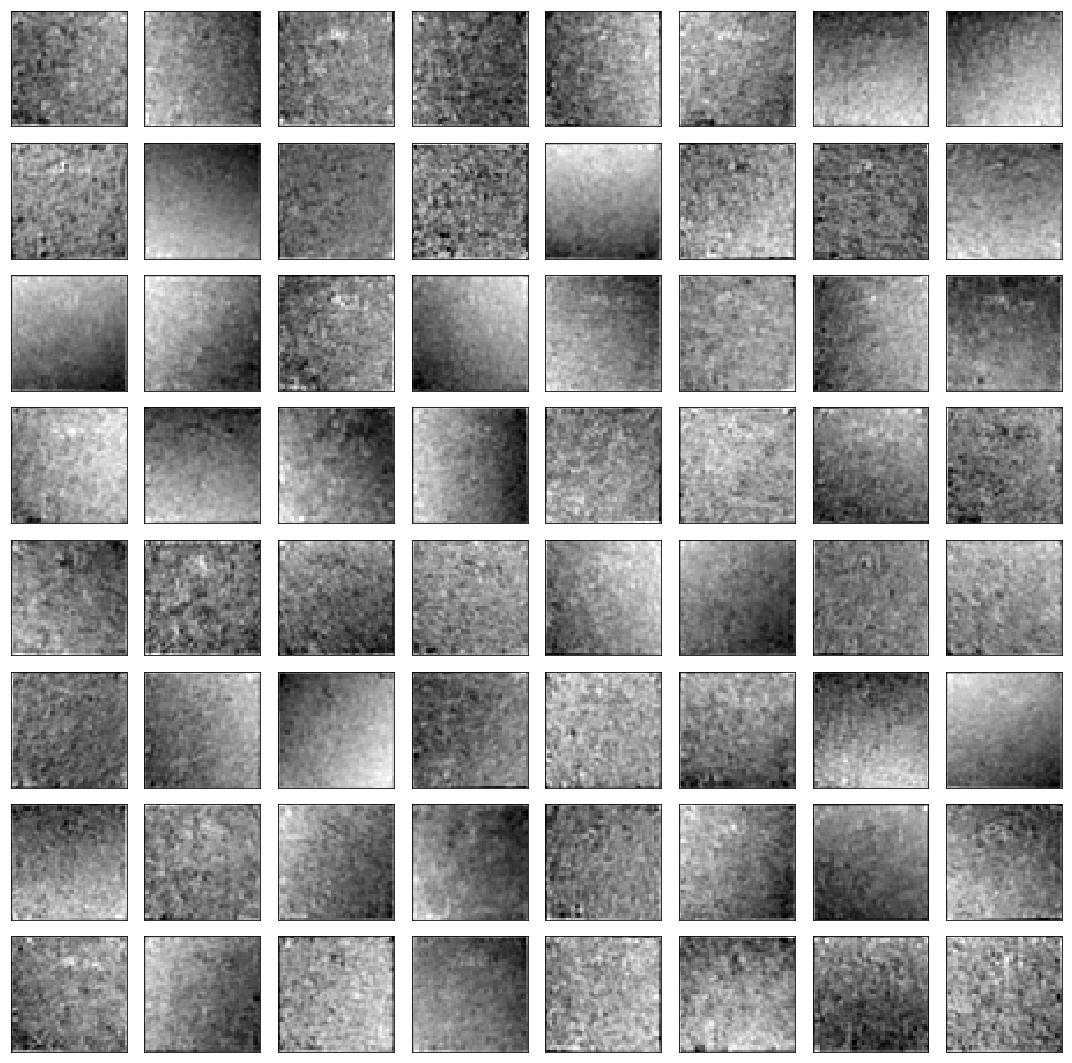

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


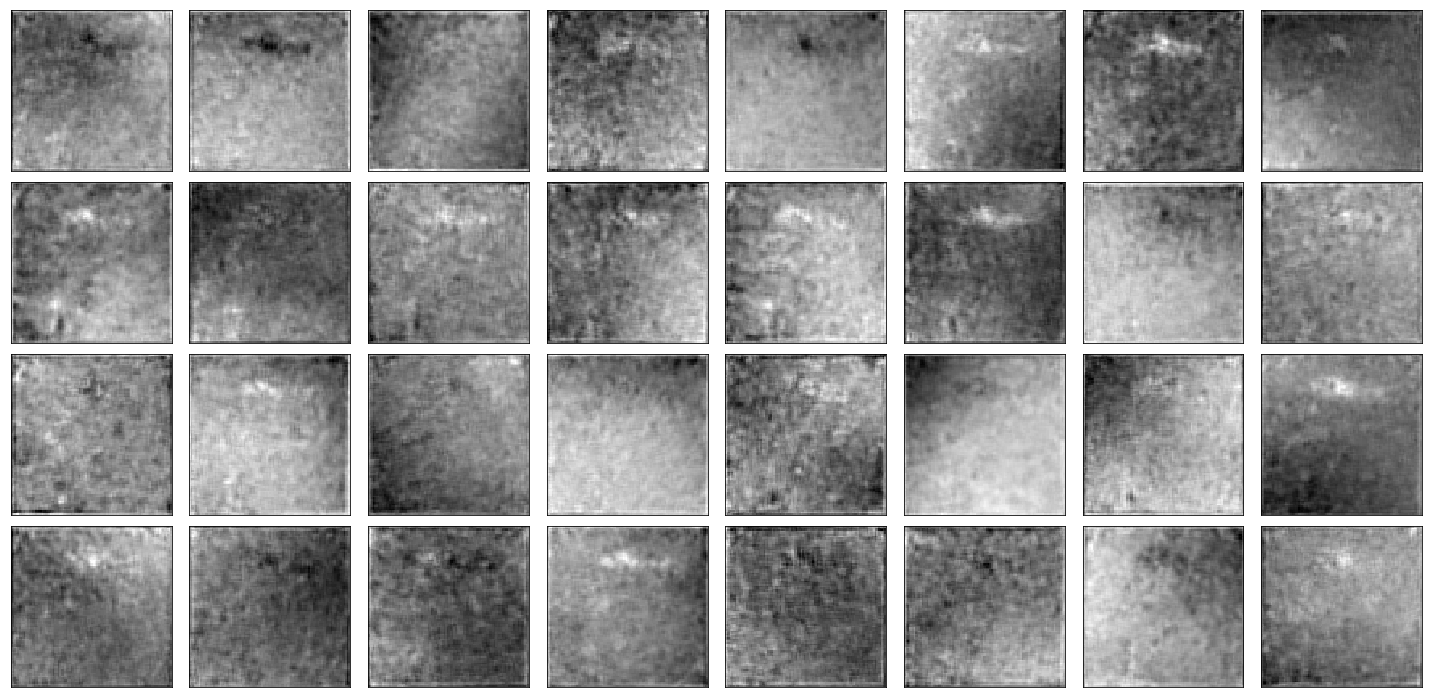

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

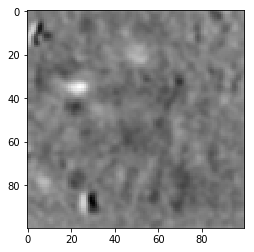

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


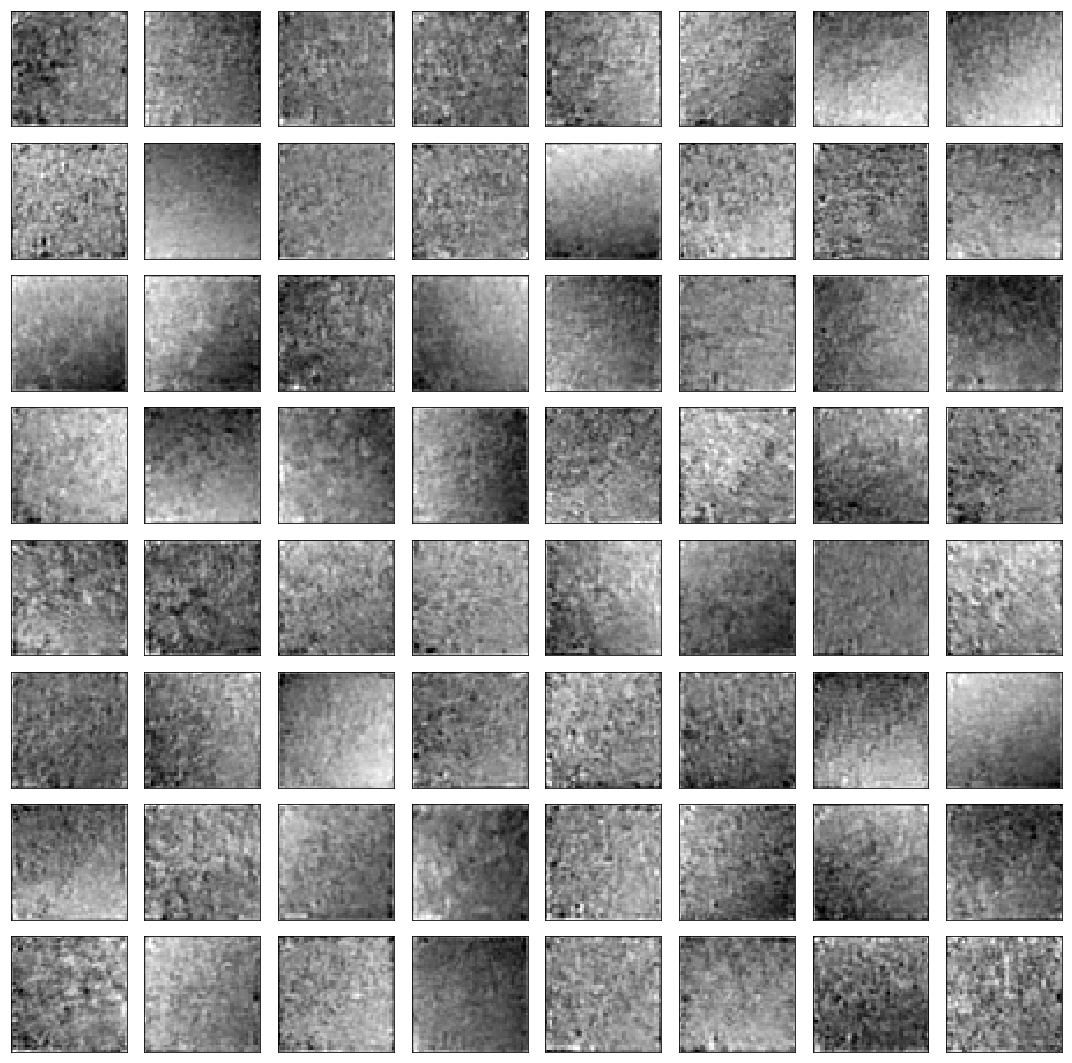

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_9', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


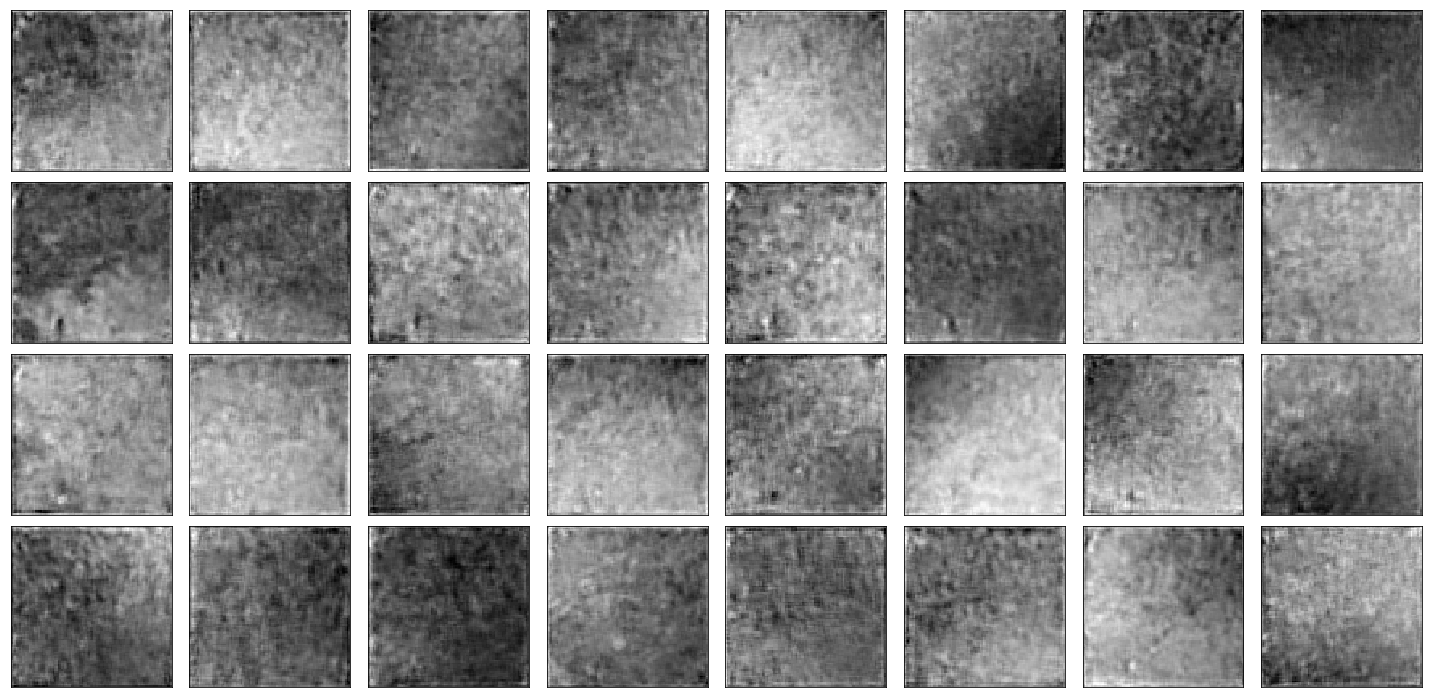

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_36', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

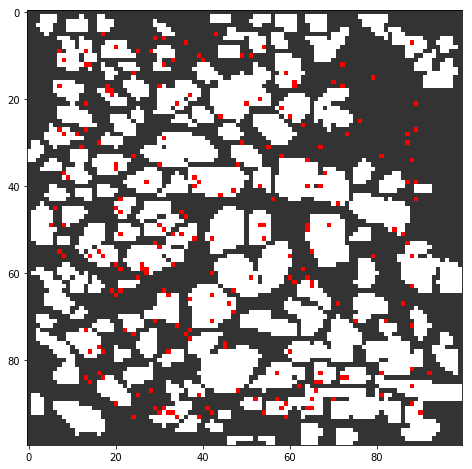

In [42]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

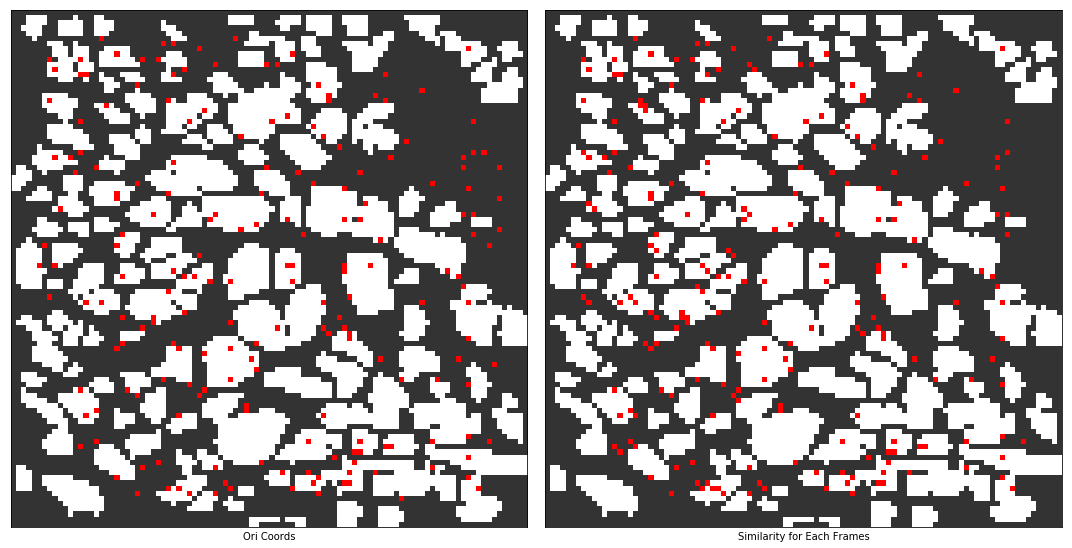

Counts:  213


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)